In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
key_id='YOUR_KEY_ID'
access_key='YOUR_ACCESS_KEY'
region="us-east-2"
sc.setSystemProperty("com.amazonaws.services.s3.enableV4","true")
sc._jsc.hadoopConfiguration().set("fs.s3a.awsAccessKeyId",key_id)
sc._jsc.hadoopConfiguration().set("fs.s3a.awsSecretAccessKey",access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint","s3-"+region+".amazonaws.com")

In [4]:
#Path to all the datasets
complete_dataset_path = "PATH/TO/COMPLETE/DATASET"
small_dataset_path = "PATH/TO/SMALL/DATASET"
user_dataset_path = "PATH/TO/USER/DATASET"

In [5]:
complete_users_file = user_dataset_path+'users.dat'
complete_users_raw_data = sc.textFile(complete_users_file)

In [6]:
#Loading the data of users.dat in 'user' RDD
user = complete_users_raw_data.map(lambda x: (x.split('::'))).toDF()

In [7]:
#Setting header to columns of the RDD
u_cols=['user_id', 'gender', 'age', 'occupation', 'zip_code']
users=user.toPandas()
users.columns = u_cols
users.head(10)

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


In [8]:
#Converting data type of each column from string to int
u_cols=['user_id', 'gender', 'age', 'occupation', 'zip_code']
users['user_id']=users['user_id'].astype(int)
users['age']=users['age'].astype(int)
users['occupation']=users['occupation'].astype(int)

In [9]:
m_ratings_file = user_dataset_path+'ratings.dat'
m_ratings_raw_data = sc.textFile(m_ratings_file)
rating = m_ratings_raw_data.map(lambda x: (x.split('::'))).toDF()
r_cols=['user_id','movie_id','rating','timestamp']
ratings=rating.toPandas()
ratings.columns = r_cols
ratings.head(10)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [10]:
ratings['user_id']=ratings['user_id'].astype(int)
ratings['movie_id']=ratings['movie_id'].astype(int)
ratings['rating']=ratings['rating'].astype(int)
ratings['timestamp']=ratings['timestamp'].astype(int)

In [11]:
#Loading data from movies.dat and seperating the release year from the movie title into a different column
m_movies_file = user_dataset_path+'movies.dat'
m_movies_raw_data = sc.textFile(m_movies_file)
movie = m_movies_raw_data.map(lambda x: ( [x.split('::')[0] , '('.join(x.split('::')[1].split('(')[0:-1]) \
                                          , x.split('::')[1].split('(')[-1].replace(')',''), x.split('::')[2]] )).toDF()
m_cols=['movie_id','title','release_year','genres']
movies=movie.toPandas()
movies.columns = m_cols
movies.head(10)

,movie_id,title,release_year,genres
0,1,Toy Story,1995,Animation|Children's|Comedy
1,2,Jumanji,1995,Adventure|Children's|Fantasy
2,3,Grumpier Old Men,1995,Comedy|Romance
3,4,Waiting to Exhale,1995,Comedy|Drama
4,5,Father of the Bride Part II,1995,Comedy
5,6,Heat,1995,Action|Crime|Thriller
6,7,Sabrina,1995,Comedy|Romance
7,8,Tom and Huck,1995,Adventure|Children's
8,9,Sudden Death,1995,Action
9,10,GoldenEye,1995,Action|Adventure|Thriller


In [12]:
movies['movie_id']=movies['movie_id'].astype(int)
movies['release_year']=movies['release_year'].astype(int)

In [13]:
# create one merged DataFrame of movies.dat, ratings.dat and users.dat
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)

In [14]:
lens.head(10)

,movie_id,title,release_year,genres,user_id,rating,timestamp,gender,age,occupation,zip_code
0,1,Toy Story,1995,Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas,1995,Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13,1995,Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope,1977,Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List,1993,Drama|War,1,5,978824195,F,1,10,48067
5,531,"Secret Garden, The",1993,Children's|Drama,1,4,978302149,F,1,10,48067
6,588,Aladdin,1992,Animation|Children's|Comedy|Musical,1,4,978824268,F,1,10,48067
7,594,Snow White and the Seven Dwarfs,1937,Animation|Children's|Musical,1,4,978302268,F,1,10,48067
8,595,Beauty and the Beast,1991,Animation|Children's|Musical,1,5,978824268,F,1,10,48067
9,608,Fargo,1996,Crime|Drama|Thriller,1,4,978301398,F,1,10,48067


In [15]:
#Display 25 movies with the highest number of ratings
most_rated = lens.groupby('title').size().sort_values(ascending=False)[:25]
most_rated

title
American Beauty                                    3428
Star Wars: Episode IV - A New Hope                 2991
Star Wars: Episode V - The Empire Strikes Back     2990
Star Wars: Episode VI - Return of the Jedi         2883
Jurassic Park                                      2672
Saving Private Ryan                                2653
Terminator 2: Judgment Day                         2649
Matrix, The                                        2590
Back to the Future                                 2583
Silence of the Lambs, The                          2578
Men in Black                                       2538
Raiders of the Lost Ark                            2514
Fargo                                              2513
Sixth Sense, The                                   2459
Braveheart                                         2443
Shakespeare in Love                                2369
Princess Bride, The                                2318
Schindler's List                          

In [16]:
#Grouping the above data on the basis of movie title and showing its size and mean
movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()

rating          
                          size      mean
title                                   
$1,000,000 Duck             37  3.027027
'Night Mother               70  3.371429
'Til There Was You          52  2.692308
'burbs, The                303  2.910891
...And Justice for All     199  3.713568

In [17]:
# sort by rating mean
movie_stats.sort_values([('rating', 'mean')], ascending=False).head()

rating     
                     size mean
title                         
Smashing Time           2  5.0
Song of Freedom         1  5.0
One Little Indian       1  5.0
Ulysses (Ulisse)        1  5.0
Baby, The               1  5.0

In [18]:
#Removing movies with less then 100 ratings and displaying top 15 movies on the basis of rating mean.
atleast_100 = movie_stats['rating']['size'] >= 100
movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:15]

rating          
                                                     size      mean
title                                                              
Seven Samurai (The Magnificent Seven) (Shichini...    628  4.560510
Shawshank Redemption, The                            2227  4.554558
Godfather, The                                       2223  4.524966
Close Shave, A                                        657  4.520548
Usual Suspects, The                                  1783  4.517106
Schindler's List                                     2304  4.510417
Wrong Trousers, The                                   882  4.507937
Sunset Blvd. (a.k.a. Sunset Boulevard)                470  4.491489
Raiders of the Lost Ark                              2514  4.477725
Rear Window                                          1050  4.476190
Paths of Glory                                        230  4.473913
Star Wars: Episode IV - A New Hope                   2991  4.453694
Third Man, The                                        480  4.452083
Dr. Strangelove or: How I Learned to Stop Worry...   1367  4.449890
Wallace & Gromit: The Best of Aardman Animation       438  4.426941

In [19]:
#movie_id of top 50 movies with highest number of ratings
most_50 = lens.groupby('movie_id').size().sort_values(ascending=False)[:50]
most_50

movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
2028    2653
589     2649
2571    2590
1270    2583
593     2578
1580    2538
1198    2514
608     2513
2762    2459
110     2443
2396    2369
1197    2318
527     2304
1617    2288
1265    2278
1097    2269
2628    2250
2997    2241
318     2227
858     2223
356     2194
2716    2181
296     2171
1240    2098
1       2077
1214    2024
2916    1996
457     1995
3578    1924
1200    1820
541     1800
2987    1799
1259    1785
50      1783
34      1751
2791    1731
780     1730
3175    1728
1193    1725
919     1718
924     1716
1127    1715
2355    1703
1387    1697
1221    1692
dtype: int64

In [20]:
#Grouping the ratings.dat of exploratory dataset on the basis of age group and displaying its size and mean
ratings_mean_per_age_group=lens.groupby('age').agg({'rating': [np.size, np.mean]})
ratings_mean_per_age_group

rating          
       size      mean
age                  
1     27211  3.549520
18   183536  3.507573
25   395556  3.545235
35   199003  3.618162
45    83633  3.638062
50    72490  3.714512
56    38780  3.766632

age
1      222
18    1103
25    2096
35    1193
45     550
50     496
56     380
Name: user_id, dtype: int64


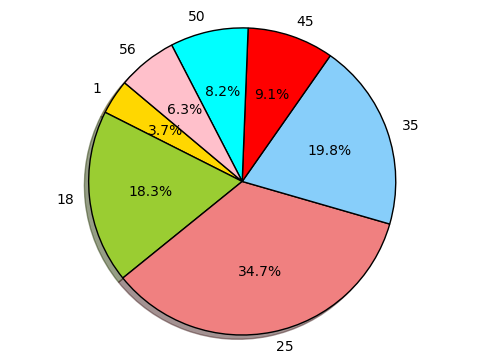

In [21]:
#   *  1:  "Under 18"
#   * 18:  "18-24"
#   * 25:  "25-34"
#   * 35:  "35-44"
#   * 45:  "45-49"
#   * 50:  "50-55"
#   * 56:  "56+"
#Displaying a pie chart of the amount of users from each age group
print(users.groupby('age').count().user_id)
import matplotlib.pyplot as plt
labels = ['1', '18', '25', '35', '45', '50', '56']
means = users.groupby('age').count().user_id
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'cyan', 'pink']
 
# Plot
plt.pie(means, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

age
1     3.549520
18    3.507573
25    3.545235
35    3.618162
45    3.638062
50    3.714512
56    3.766632
Name: mean, dtype: float64


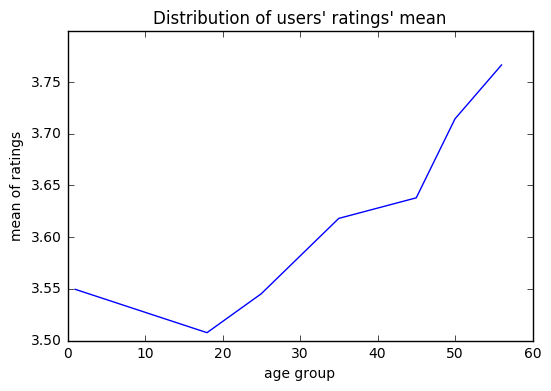

In [22]:
#Displaying a line chart of mean ratings given by each age group
print(ratings_mean_per_age_group['rating']['mean'])
plt.plot(ratings_mean_per_age_group['rating']['mean'])
plt.title("Distribution of users' ratings' mean")
plt.ylabel('mean of ratings')
plt.xlabel('age group');

In [23]:
#Sample of mean of ratings given by each age group to top 50 movies with highest number of ratings
lens.set_index('movie_id', inplace=True)
by_age = lens.loc[most_50.index].groupby(['title', 'age'])
by_age.rating.mean().head(15)

title                   age
2001: A Space Odyssey   1      4.150000
                        18     3.923404
                        25     4.024712
                        35     4.080940
                        45     4.168478
                        50     4.241379
                        56     4.118280
Abyss, The              1      3.909091
                        18     3.893939
                        25     3.614509
                        35     3.686217
                        45     3.683099
                        50     3.513514
                        56     3.509091
Airplane!               1      3.794872
Name: rating, dtype: float64

In [24]:
#Displaying portion of the same data in tabular form for readability
by_age.rating.mean().unstack(1).fillna(0)[20:30]

age,1,18,25,35,45,50,56
title,,,,,,,
"Godfather: Part II, The",3.935484,4.373494,4.428135,4.341667,4.282051,4.259494,4.309524
Groundhog Day,3.805195,3.853933,4.002230,3.983529,4.010695,3.907407,3.894118
Independence Day (ID4),3.854839,3.522911,3.392593,3.590214,3.687023,3.535088,3.540000
Jaws,4.225000,3.867089,4.144882,4.183024,4.060000,4.082645,4.086207
Jurassic Park,3.808989,3.737523,3.702000,3.795367,3.940367,3.766839,3.911504
L.A. Confidential,4.217391,4.248157,4.238636,4.168919,4.191176,4.277487,4.120690
"Matrix, The",4.464646,4.446208,4.389895,4.249476,4.026316,3.920530,3.964912
Men in Black,3.840000,3.618677,3.665294,3.843496,3.844560,3.977901,3.862069
One Flew Over the Cuckoo's Nest,4.222222,4.457831,4.412371,4.389578,4.319372,4.310345,4.411765


In [25]:
#Storing the mean of ratings given by both the genders individually to each movie
lens.reset_index('movie_id', inplace=True)
pivoted = lens.pivot_table(index=['movie_id', 'title'],
                           columns=['gender'],
                           values='rating',
                           fill_value=0)
pivoted.head()

,gender,F,M
movie_id,title,,
1,Toy Story,4.187817,4.130552
2,Jumanji,3.278409,3.175238
3,Grumpier Old Men,3.073529,2.994152
4,Waiting to Exhale,2.976471,2.482353
5,Father of the Bride Part II,3.212963,2.888298


In [26]:
#Calculating the difference between the average rating by females and average rating by males
pivoted['diff'] = pivoted.M - pivoted.F
pivoted.head()

,gender,F,M,diff
movie_id,title,,,
1,Toy Story,4.187817,4.130552,-0.057265
2,Jumanji,3.278409,3.175238,-0.103171
3,Grumpier Old Men,3.073529,2.994152,-0.079377
4,Waiting to Exhale,2.976471,2.482353,-0.494118
5,Father of the Bride Part II,3.212963,2.888298,-0.324665


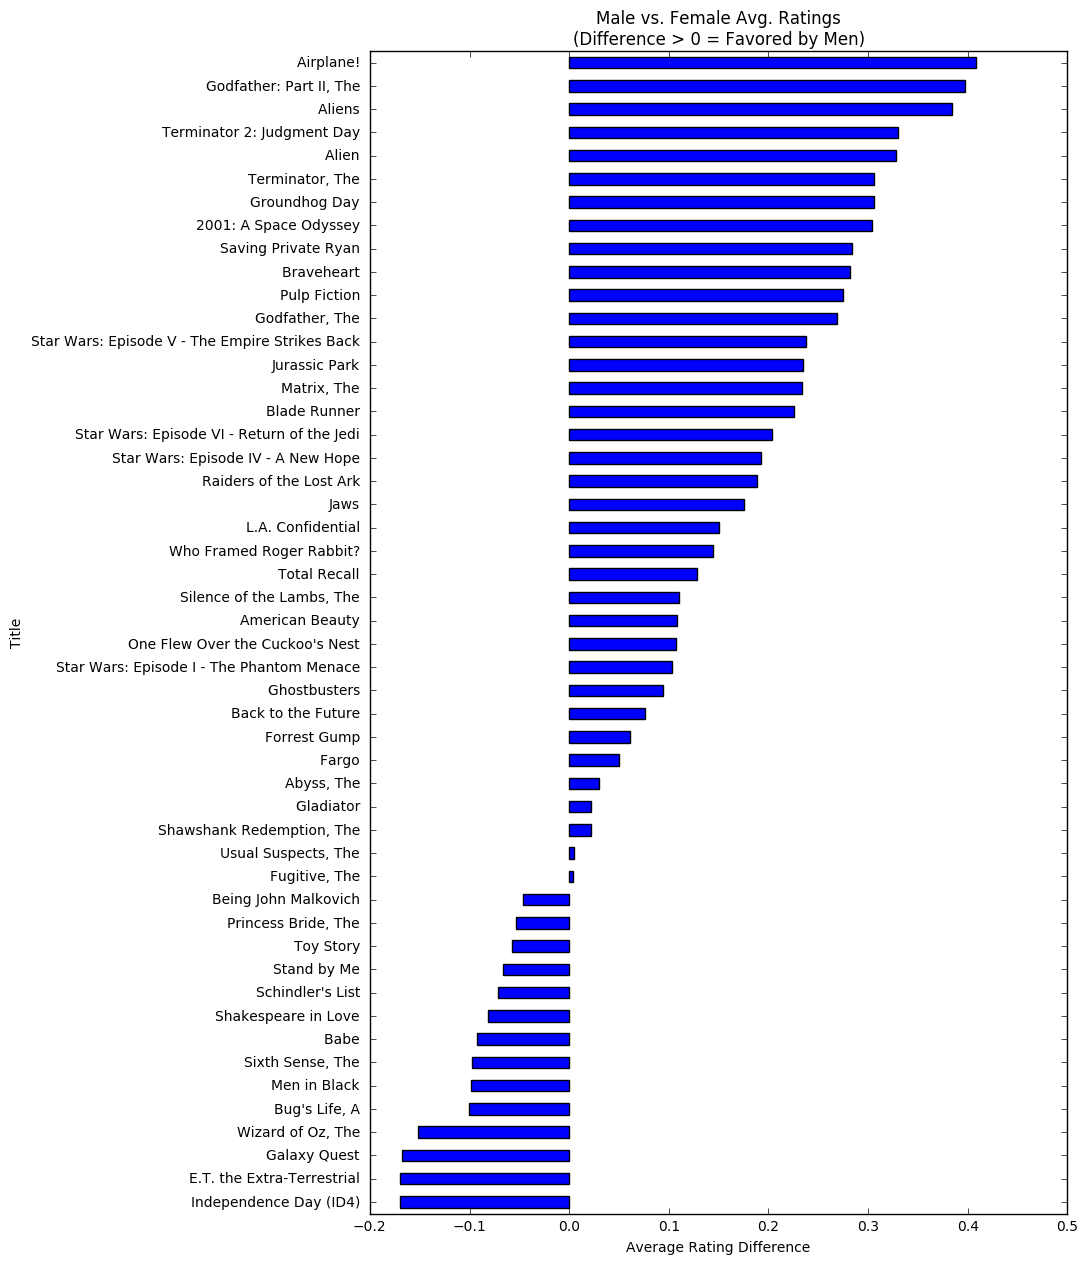

In [27]:
#Displaying a horizontal bar graph with bars on +ve x-axis representing movies liked by males and movies on -ve x-axis
#representing movies liked by females.
pivoted.reset_index('movie_id', inplace=True)
disagreements = pivoted[pivoted.movie_id.isin(most_50.index)]['diff']
disagreements.sort_values().plot(kind='barh', figsize=[9, 15])
plt.title('Male vs. Female Avg. Ratings\n(Difference > 0 = Favored by Men)')
plt.ylabel('Title')
plt.xlabel('Average Rating Difference');

In [28]:
#Removing '%' as the first character of complete_ratings_cleaned.csv file
f = open('complete_ratings_cleaned.csv')
first_line, remainder = f.readline(), f.read()
t = open('complete_ratings_cleaned_corrected.csv',"w")
t.write('user_id%movie_id%rating%timestamp' + "\n")
t.write(remainder)
t.close()

In [29]:
#Saving the cleaned complete ratings file as 'complete_ratings_cleaned_corrected.csv'
complete_ratings = pd.read_csv('complete_ratings_cleaned_corrected.csv',sep='%')
complete_ratings

,user_id,movie_id,rating,timestamp
0,1,110,1.0,2015-03-09 22:52:09
1,1,147,4.5,2015-03-09 23:07:15
2,1,858,5.0,2015-03-09 22:52:03
3,1,1221,5.0,2015-03-09 22:52:26
4,1,1246,5.0,2015-03-09 22:52:36
5,1,1968,4.0,2015-03-09 23:02:28
6,1,2762,4.5,2015-03-09 22:48:20
7,1,2918,5.0,2015-03-09 22:53:13
8,1,2959,4.0,2015-03-09 22:53:21
9,1,4226,4.0,2015-03-09 23:03:48


In [35]:
#Removing '%' as the first character of complete_movies_cleaned.csv file
f = open('complete_movies_cleaned.csv')
first_line, remainder = f.readline(), f.read()
t = open('complete_movies_cleaned_corrected.csv',"w")
t.write('movie_id%title%genres%year' + "\n")
t.write(remainder)
t.close()

In [36]:
#Loading the cleaned movie data
complete_movies=pd.read_csv('complete_movies_cleaned_corrected.csv',sep='%')
complete_movies

,movie_id,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
5,6,Heat,Action|Crime|Thriller,1995
6,7,Sabrina,Comedy|Romance,1995
7,8,Tom and Huck,Adventure|Children,1995
8,9,Sudden Death,Action,1995
9,10,GoldenEye,Action|Adventure|Thriller,1995


In [37]:
#Merging the movie and rating data
merge_movie_ratings=pd.merge(complete_movies, complete_ratings, on='movie_id', how='inner')
merge_movie_ratings.head(10)

,movie_id,title,genres,year,user_id,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,8,4.0,2002-02-11 16:06:36
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,9,4.5,2004-01-11 16:06:20
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,12,4.0,1999-11-29 21:50:05
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,20,4.0,2013-05-12 12:22:28
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,24,4.0,2001-01-19 02:05:38
5,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,27,3.5,2008-01-24 22:21:45
6,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,34,3.0,2017-06-29 18:29:23
7,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,37,3.5,2011-04-01 05:21:48
8,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,40,4.0,1997-05-01 19:37:33
9,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,41,3.5,2015-10-19 12:05:36


In [38]:
#user_id and number of ratings of 10 users who have given least number of ratings
merge_movie_ratings['user_id'].value_counts().tail(10)

209503    1
57398     1
114486    1
69752     1
180755    1
211098    1
122905    1
96467     1
135199    1
175443    1
Name: user_id, dtype: int64

In [39]:
merge_movie_ratings['rating']=merge_movie_ratings['rating'].astype(float)
merge_movie_ratings['movie_id']=merge_movie_ratings['movie_id'].astype(int)
merge_movie_ratings['user_id']=merge_movie_ratings['user_id'].astype(int)

In [41]:
#Grouping the merged data on the basis of user_id and displaying its size and mean for each rest columns
ratings_by_user=merge_movie_ratings.groupby('user_id')
ratings_by_user=ratings_by_user.agg([np.size, np.mean])
ratings_by_user

movie_id                year               rating          
            size          mean  size         mean    size      mean
user_id                                                            
1             26  45272.192308    26  2001.576923    26.0  4.288462
2             22    600.136364    22  1993.545455    22.0  3.318182
3             10   1536.700000    10  1987.000000    10.0  3.100000
4             62   2773.838710    62  1996.548387    62.0  3.500000
5             26   1590.423077    26  1979.769231    26.0  4.269231
6              4   1600.500000     4  1982.750000     4.0  3.750000
7             50  47913.760000    50  2006.080000    50.0  3.390000
8            113   2826.902655   113  1988.194690   113.0  2.991150
9             84   3622.571429    84  1996.321429    84.0  3.851190
10            13    404.000000    13  1992.846154    13.0  4.230769
11           221  37799.095023   221  2003.529412   221.0  3.208145
12           248   1355.169355   248  1988.745968   248.0  3.854839
13            10  16974.000000    10  1996.100000    10.0  2.900000
14             5  34878.600000     5  2000.600000     5.0  3.400000
15           224  21357.406250   224  1992.723214   224.0  3.727679
16           181  37812.441989   181  1998.767956   181.0  4.414365
17            24   3406.333333    24  1997.458333    24.0  3.583333
18             6   1292.666667     6  1980.666667     6.0  4.166667
19            15   1728.733333    15  1984.333333    15.0  2.266667
20           266  39561.154135   266  1998.394737   266.0  3.855263
21            30  32891.133333    30  1998.366667    30.0  4.633333
22            38   2025.210526    38  1993.131579    38.0  2.763158
23            12   2195.083333    12  1978.000000    12.0  3.833333
24           634   2166.148265   634  1989.435331   634.0  3.474763
25            33    324.303030    33  1993.515152    33.0  3.393939
26             5   2477.200000     5  1992.000000     5.0  3.600000
27            80   4351.812500    80  1986.275000    80.0  3.643750
28            26  25934.615385    26  1995.500000    26.0  3.692308
29            56   2427.696429    56  1987.107143    56.0  3.553571
30           120   2104.700000   120  1991.208333   120.0  3.950000
...          ...           ...   ...          ...     ...       ...
270867        32  17362.125000    32  1996.312500    32.0  4.156250
270868        89  41171.528090    89  2002.280899    89.0  4.011236
270869       111   1437.981982   111  1984.558559   111.0  3.630631
270870        19   2017.473684    19  1986.894737    19.0  3.710526
270871       260  21137.603846   260  1994.565385   260.0  3.657692
270872       221   6647.484163   221  1977.407240   221.0  3.977376
270873         4   1513.500000     4  1965.000000     4.0  2.375000
270874        17   1203.647059    17  1988.235294    17.0  2.823529
270875        36  13999.916667    36  1991.833333    36.0  3.208333
270876        16   3431.562500    16  1987.687500    16.0  2.968750
270877        68    310.279412    68  1992.867647    68.0  3.720588
270878        16   2497.500000    16  1995.187500    16.0  3.593750
270879       409   3328.921760   409  1993.557457   409.0  2.776284
270880        10   1607.700000    10  1979.200000    10.0  3.800000
270881        44   2277.363636    44  1985.590909    44.0  3.261364
270882        10   1515.800000    10  1994.800000    10.0  4.200000
270883        26    428.461538    26  1992.461538    26.0  3.423077
270884        33  21363.333333    33  2001.545455    33.0  3.893939
270885       144  12449.687500   144  1995.833333   144.0  4.163194
270886        32  76984.062500    32  2008.750000    32.0  3.343750
270887      2455  58783.573523  2455  2002.053360  2455.0  3.638900
270888         6   1656.500000     6  1986.833333     6.0  4.166667
270889        15   2730.000000    15  1997.400000    15.0  3.200000
270890        11   1815.545455    11  1973.181818    11.0  3.454545
270891        42    353.928571    42  1994.238095    42.0  4.095

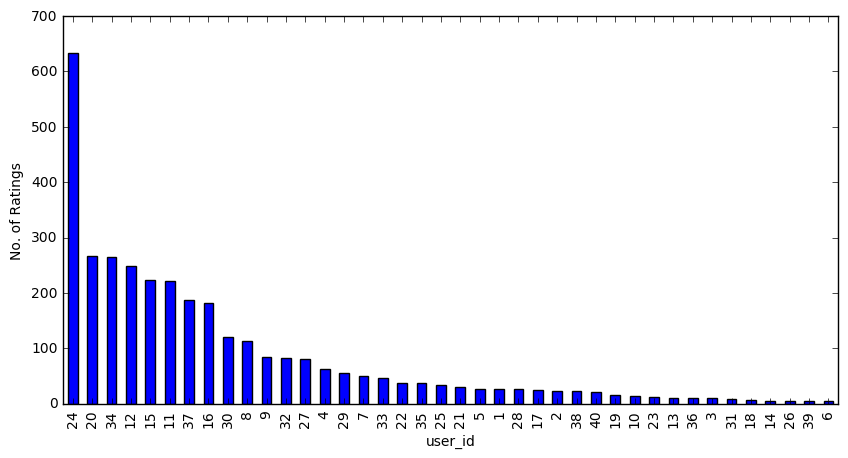

In [42]:
#Plotting bar graph for top 40 users with highest number of ratings
ratings_by_user = ratings_by_user.drop('movie_id', axis=1)
plt=ratings_by_user['rating']['size'].head(40).sort_values(ascending=False).plot(kind='bar',figsize=(10,5))
plt.set(ylabel="No. of Ratings")

In [43]:
#Grouping by movies and plotting the graphs
ratings_by_movies = merge_movie_ratings.groupby('movie_id').agg([np.mean, np.size])
ratings_by_movies.shape

(41534, 6)

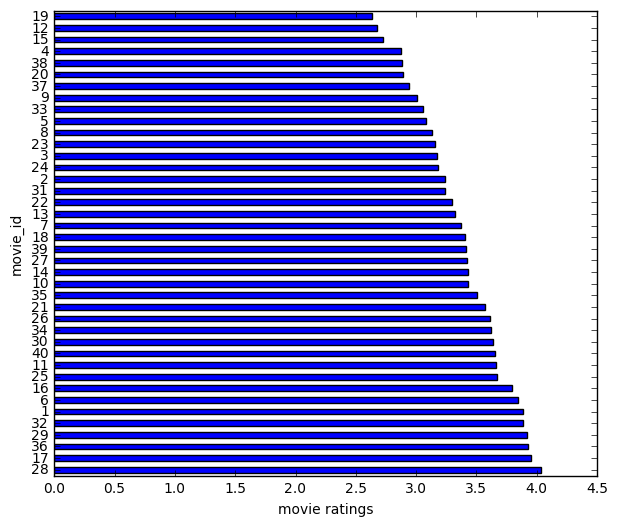

In [44]:
#Plotting horizontal graph for top 40 movie ids with highest mean of rating
ratings_by_movies=ratings_by_movies.drop('user_id',axis=1)
plt=ratings_by_movies['rating']['mean'].head(40).sort_values(ascending=False).plot(kind='barh',figsize=(7,6))
plt.set(xlabel="movie ratings")

              mean  size
movie_id                
174891    1.000000   1.0
174915    0.500000   1.0
174917    1.000000   1.0
175273    0.500000   2.0
175319    0.500000   1.0
175351    0.500000   1.0
175475    0.631579  19.0
175487    1.000000   1.0
175547    0.500000   1.0
175551    0.500000   1.0
175559    0.750000   2.0
175583    0.500000   2.0
175821    0.500000   1.0
175983    1.000000   1.0
176003    1.000000   1.0
176005    1.000000   1.0
176025    1.000000   1.0
176195    0.500000   1.0
176207    0.500000   1.0
176273    1.000000   1.0


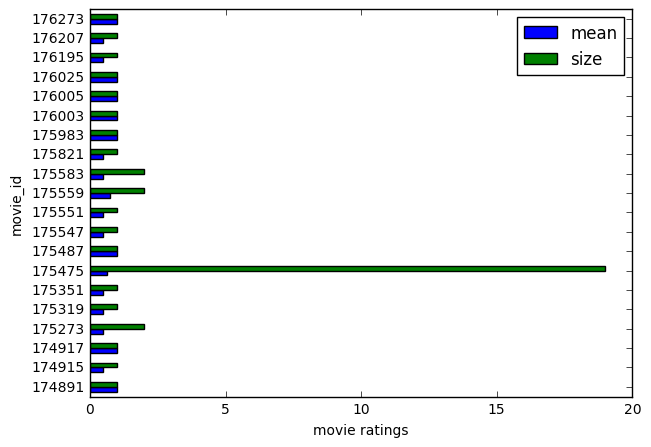

In [45]:
#Extracting the movies with low ratings. 
low_rated_movies_filter = ratings_by_movies['rating']['mean']<1.5
low_rated_movies = ratings_by_movies[low_rated_movies_filter]['rating'].tail(20)
print (low_rated_movies)
plt = low_rated_movies.head(25).plot(kind='barh', figsize=(7,5))
plt.set(xlabel="movie ratings")

              mean  size
movie_id                
176169    3.500000   1.0
176171    4.000000   1.0
176177    3.500000   1.0
176181    4.500000   1.0
176183    4.000000   1.0
176185    4.500000   1.0
176193    3.500000   1.0
176197    4.000000   1.0
176199    3.500000   1.0
176201    3.500000   1.0
176211    3.764706  17.0
176213    3.500000   1.0
176217    5.000000   1.0
176223    4.000000   1.0
176239    3.750000   2.0
176245    4.500000   1.0
176249    3.500000   2.0
176259    3.500000   1.0
176267    4.000000   1.0
176271    5.000000   1.0


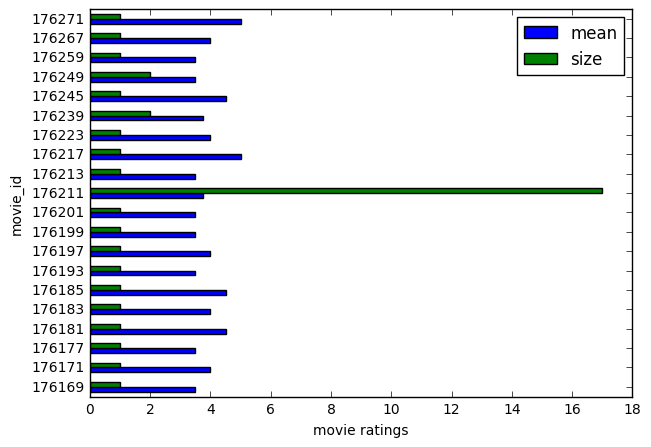

In [46]:
#Extracting the movies with high ratings. 
high_rated_movies_filter = ratings_by_movies['rating']['mean']>=3.5
high_rated_movies = ratings_by_movies[high_rated_movies_filter]['rating'].tail(20)
print (high_rated_movies)
plt = high_rated_movies.head(25).plot(kind='barh', figsize=(7,5))
plt.set(xlabel="movie ratings")